In [2]:
#source: https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np


bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [ ]:
class VAE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
    super(VAE, self).__init__()
    
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1)
    self.fc2 = nn.Linear(h_dim1, h_dim2)
    self.fc31 = nn.Linear(h_dim2, z_dim)
    self.fc32 = nn.Linear(h_dim2, z_dim)
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2)
    self.fc5 = nn.Linear(h_dim2, h_dim1)
    self.fc6 = nn.Linear(h_dim1, x_dim)
      
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    return self.fc31(h), self.fc32(h) # mu, log_var
  
  def sampling(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu) # return z sample
      
  def decoder(self, z):
    h = F.relu(self.fc4(z))
    h = F.relu(self.fc5(h))
    return F.sigmoid(self.fc6(h)) 
  
  def forward(self, x):
    mu, log_var = self.encoder(x.view(-1, 784))
    z = self.sampling(mu, log_var)
    return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 256, h_dim2=128, z_dim=4)
if torch.cuda.is_available():
  vae.cuda()
if torch.xpu.is_available():
  vae.xpu()

print('total parameters: ', sum([p.numel() for p in vae.parameters()]))

total parameters:  470040


In [61]:
def view_samples(vae, z_dim=2):
  with torch.no_grad():
    z = torch.randn(64, z_dim).xpu()
    sample = vae.decoder(z)
    sample = sample.view(-1, 28, 28).cpu()
  
  img_list = torch.unbind(sample, dim=0)
  num_rows = 8
  num_cols = 8
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols/2, num_rows/2)) # Adjust figsize as needed
  for i in range(num_rows):
    for j in range(num_cols):
      index = i * num_cols + j # Calculate index for your image data
      if index < len(img_list): # Check if you have enough images
        ax = axes[i, j] # Get the current axis
        ax.imshow(img_list[index], cmap='grey') # Display the image
        ax.axis('off') # Turn off axes for cleaner display
      else:
        # If you have fewer images than subplots, turn off empty axes
        axes[i, j].axis('off')
  plt.tight_layout(pad=0) # Adjust subplot parameters for a tight layout
  plt.show() # Display the plot"

In [57]:
import inspect
inspect.getsource(view_samples)

"def view_samples(vae, z_dim=2):\n  with torch.no_grad():\n    z = torch.randn(64, z_dim).xpu()#.cuda()\n    sample = vae.decoder(z)#.cuda()\n    sample = sample.view(-1, 28, 28).cpu()\n  img_list = torch.unbind(sample, dim=0)\n\n  num_rows = 8\n  num_cols = 8\n  fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols/2, num_rows/2)) # Adjust figsize as needed\n  for i in range(num_rows):\n    for j in range(num_cols):\n      index = i * num_cols + j # Calculate index for your image data\n      if index < len(img_list): # Check if you have enough images\n        ax = axes[i, j] # Get the current axis\n        ax.imshow(img_list[index], cmap='grey') # Display the image\n        ax.axis('off') # Turn off axes for cleaner display\n      else:\n        # If you have fewer images than subplots, turn off empty axes\n        axes[i, j].axis('off')\n  plt.tight_layout(pad=0) # Adjust subplot parameters for a tight layout\n  plt.show() # Display the plot\n"

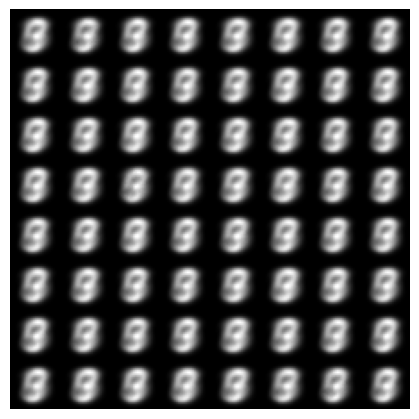

In [62]:
view_samples(vae, 4)

In [44]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var, scale_BCE=1.0, scale_KLD=1.0):
  BCE = scale_BCE * F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  KLD = scale_KLD * -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return BCE, KLD

In [48]:
def train(epoch):
  vae.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.xpu()
    optimizer.zero_grad()
    
    recon_batch, mu, log_var = vae(data)
    BCE, KLD = loss_function(recon_batch, data, mu, log_var, scale_KLD=50.0)
    loss = BCE + KLD
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 200 == 0:
      print(
        f'''Train Epoch: {epoch} [{batch_idx}/{len(data)}] Loss: {loss.item()/len(data):.4f}, BCE Loss: {BCE.item()/len(data):.4f}, KLD Loss: {KLD.item()/len(data):.4f}''')
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [49]:
def test():
  vae.eval()
  test_loss= 0
  with torch.no_grad():
    for data, _ in test_loader:
      data = data.xpu()
      recon, mu, log_var = vae(data)
      
      # sum up batch loss
      BCE, KLD = loss_function(recon, data, mu, log_var)
      test_loss += (BCE + KLD).item()
      
  test_loss /= len(test_loader.dataset)
  print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/100] Loss: 521.6027, BCE Loss: 112.7107, KLD Loss: 408.8920
Train Epoch: 1 [200/100] Loss: 208.0788, BCE Loss: 207.9334, KLD Loss: 0.1455
Train Epoch: 1 [400/100] Loss: 201.6656, BCE Loss: 201.6265, KLD Loss: 0.0392
====> Epoch: 1 Average loss: 211.7734
====> Test set loss: 206.1866
Train Epoch: 2 [0/100] Loss: 210.9811, BCE Loss: 210.9579, KLD Loss: 0.0232
Train Epoch: 2 [200/100] Loss: 219.2065, BCE Loss: 219.1908, KLD Loss: 0.0157
Train Epoch: 2 [400/100] Loss: 208.1864, BCE Loss: 208.1721, KLD Loss: 0.0143
====> Epoch: 2 Average loss: 206.4071
====> Test set loss: 206.0878
Train Epoch: 3 [0/100] Loss: 210.5202, BCE Loss: 210.5051, KLD Loss: 0.0151
Train Epoch: 3 [200/100] Loss: 197.6035, BCE Loss: 197.5964, KLD Loss: 0.0071
Train Epoch: 3 [400/100] Loss: 208.3894, BCE Loss: 208.3814, KLD Loss: 0.0079
====> Epoch: 3 Average loss: 206.3176
====> Test set loss: 206.1761
Train Epoch: 4 [0/100] Loss: 201.9692, BCE Loss: 201.9619, KLD Loss: 0.0073
Train Epoch: 4 [200/10

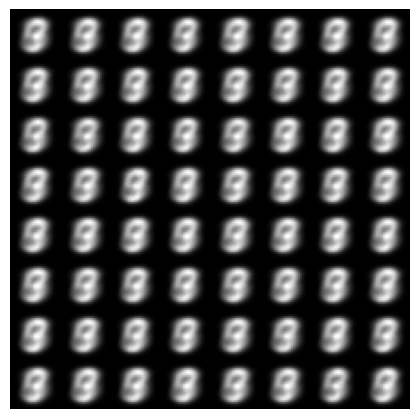

In [50]:
for epoch in range(1, 10):
  train(epoch)
  test()
view_samples(vae, 4)

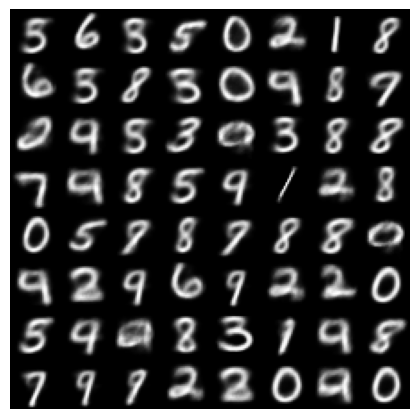

In [24]:
with torch.no_grad():
  z = torch.randn(64, 2)#.cuda()
  vae.xpu()
  #sample = vae.decoder(z)#.cuda()
  
  #save_image(sample.view(64, 1, 28, 28), './generated_vae_images/sample_' + '.png')
  view_samples(vae)

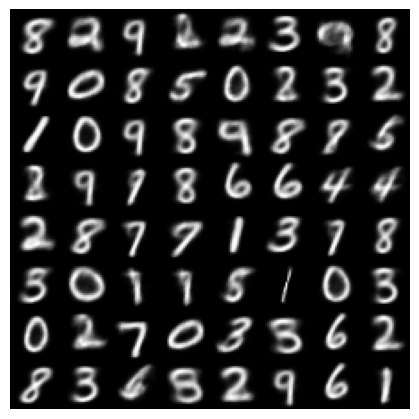

In [25]:

with torch.no_grad():
  z = torch.randn(64, 2)#.cuda()
  vae.cpu()
  sample = vae.decoder(z)#.cuda()
  sample = sample.view(-1, 28, 28)
img_list = torch.unbind(sample, dim=0)

num_rows = 8
num_cols = 8
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols/2, num_rows/2)) # Adjust figsize as needed
for i in range(num_rows):
  for j in range(num_cols):
    index = i * num_cols + j # Calculate index for your image data
    if index < len(img_list): # Check if you have enough images
      ax = axes[i, j] # Get the current axis
      ax.imshow(img_list[index], cmap='grey') # Display the image
      ax.axis('off') # Turn off axes for cleaner display
    else:
      # If you have fewer images than subplots, turn off empty axes
      axes[i, j].axis('off')
plt.tight_layout(pad=0) # Adjust subplot parameters for a tight layout
plt.show() # Display the plot

### Try sampling from a regular autoencoder

In [51]:
class AE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
    super(AE, self).__init__()
    
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1)
    self.fc2 = nn.Linear(h_dim1, h_dim2)
    self.fc3 = nn.Linear(h_dim2, z_dim)
    
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2)
    self.fc5 = nn.Linear(h_dim2, h_dim1)
    self.fc6 = nn.Linear(h_dim1, x_dim)
      
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    return self.fc3(h)
  
  def decoder(self, z):
    h = F.relu(self.fc4(z))
    h = F.relu(self.fc5(h))
    h = F.sigmoid(self.fc6(h))
    return h

  def forward(self, x):
    embd = self.encoder(x.view(-1, 784))
    repr = self.decoder(embd)
    return embd, repr

# build model
ae = AE(x_dim=784, h_dim1= 256, h_dim2=128, z_dim=4)
if torch.cuda.is_available():
  ae.cuda()
if torch.xpu.is_available():
  ae.xpu()

print('total parameters: ', sum([p.numel() for p in ae.parameters()]))

total parameters:  469524


In [ ]:
optimizer = optim.Adam(ae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x):
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  return BCE

In [54]:
def train_ae(epoch):
  ae.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.xpu()
    optimizer.zero_grad()
    
    embd, repr = ae(data)
    BCE = loss_function(repr, data)
    loss = BCE
    
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    
    if batch_idx % 200 == 0:
      print(
        f'''Train Epoch: {epoch} [{batch_idx}/{len(data)}] Loss: {loss.item()/len(data):.4f}, BCE Loss: {BCE.item()/len(data):.4f}''')
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

def test_ae():
  ae.eval()
  test_loss= 0
  with torch.no_grad():
    for data, _ in test_loader:
      data = data.xpu()
      embd, repr = ae(data)
      
      # sum up batch loss
      BCE = loss_function(repr, data)
      test_loss += (BCE).item()
      
  test_loss /= len(test_loader.dataset)
  print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/100] Loss: 109.6896, BCE Loss: 109.6896
Train Epoch: 1 [200/100] Loss: 112.2531, BCE Loss: 112.2531
Train Epoch: 1 [400/100] Loss: 106.6827, BCE Loss: 106.6827
====> Epoch: 1 Average loss: 108.9101
====> Test set loss: 110.9151
Train Epoch: 2 [0/100] Loss: 109.4343, BCE Loss: 109.4343
Train Epoch: 2 [200/100] Loss: 103.0680, BCE Loss: 103.0680
Train Epoch: 2 [400/100] Loss: 110.0181, BCE Loss: 110.0181
====> Epoch: 2 Average loss: 108.5968
====> Test set loss: 110.8975
Train Epoch: 3 [0/100] Loss: 105.0155, BCE Loss: 105.0155
Train Epoch: 3 [200/100] Loss: 109.3781, BCE Loss: 109.3781
Train Epoch: 3 [400/100] Loss: 105.9627, BCE Loss: 105.9627
====> Epoch: 3 Average loss: 108.3134
====> Test set loss: 110.6654
Train Epoch: 4 [0/100] Loss: 108.4544, BCE Loss: 108.4544
Train Epoch: 4 [200/100] Loss: 109.4588, BCE Loss: 109.4588
Train Epoch: 4 [400/100] Loss: 112.8207, BCE Loss: 112.8207
====> Epoch: 4 Average loss: 108.1326
====> Test set loss: 110.7081
Train Epoch: 5 [

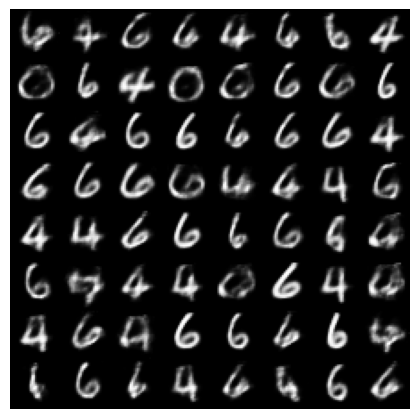

In [64]:
for epoch in range(1, 10):
  train_ae(epoch)
  test_ae()
view_samples(ae, 4)